# Detection of Dental Caries using Image Processing and Transfer Learning

## Loading the datasest using Kaggle API

In [1]:
!pip install kaggle

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [2]:
!mkdir ~/.kaggle

In [3]:
cp kaggle.json ~/.kaggle/

In [4]:
!kaggle datasets download -d snginh/teethdecay

 62% 10.0M/16.1M [00:00<00:00, 48.2MB/s]
100% 16.1M/16.1M [00:00<00:00, 65.5MB/s]


In [5]:
!unzip /content/teethdecay.zip

Archive:  /content/teethdecay.zip
  inflating: teeth_dataset/test.csv  
  inflating: teeth_dataset/test/caries/wc1.jpg  
  inflating: teeth_dataset/test/caries/wc1_0.jpg  
  inflating: teeth_dataset/test/caries/wc1_1.jpg  
  inflating: teeth_dataset/test/caries/wc1_10.jpg  
  inflating: teeth_dataset/test/caries/wc1_11.jpg  
  inflating: teeth_dataset/test/caries/wc1_12.jpg  
  inflating: teeth_dataset/test/caries/wc1_13.jpg  
  inflating: teeth_dataset/test/caries/wc1_14.jpg  
  inflating: teeth_dataset/test/caries/wc1_15.jpg  
  inflating: teeth_dataset/test/caries/wc1_16.jpg  
  inflating: teeth_dataset/test/caries/wc1_17.jpg  
  inflating: teeth_dataset/test/caries/wc1_18.jpg  
  inflating: teeth_dataset/test/caries/wc1_19.jpg  
  inflating: teeth_dataset/test/caries/wc1_2.jpg  
  inflating: teeth_dataset/test/caries/wc1_3.jpg  
  inflating: teeth_dataset/test/caries/wc1_4.jpg  
  inflating: teeth_dataset/test/caries/wc1_5.jpg  
  inflating: teeth_dataset/test/caries/wc1_6.jpg  
  

In [6]:
import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt
from tqdm import tqdm
import cv2

import warnings
warnings.filterwarnings('ignore')
import os
train_path = "/content/teeth_dataset/train/"
test_path = "/content/teeth_dataset/test"

In [7]:
from keras.models import Sequential 
from keras.layers import Conv2D, MaxPooling2D, Activation, Dropout, Flatten, Dense, BatchNormalization
from keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.utils import img_to_array, load_img
from keras.utils.vis_utils import plot_model
from glob import glob

## Getting contents of training data

In [8]:
x_data = [] 
y_data = [] 

for category in glob(train_path+'/*'):
    for file in tqdm(glob(category+'/*')):
        img_array=cv2.imread(file)
        img_array = cv2.cvtColor(img_array, cv2.COLOR_BGR2RGB)
        x_data.append(img_array) 
        y_data.append(category.split("/")[-1])
        
data=pd.DataFrame({'image': x_data,'label': y_data})

100%|██████████| 315/315 [00:00<00:00, 1480.00it/s]


In [9]:
data.shape

(1260, 2)

In [10]:
from collections import Counter
Counter(y_data)

Counter({'caries': 945, 'no-caries': 315})

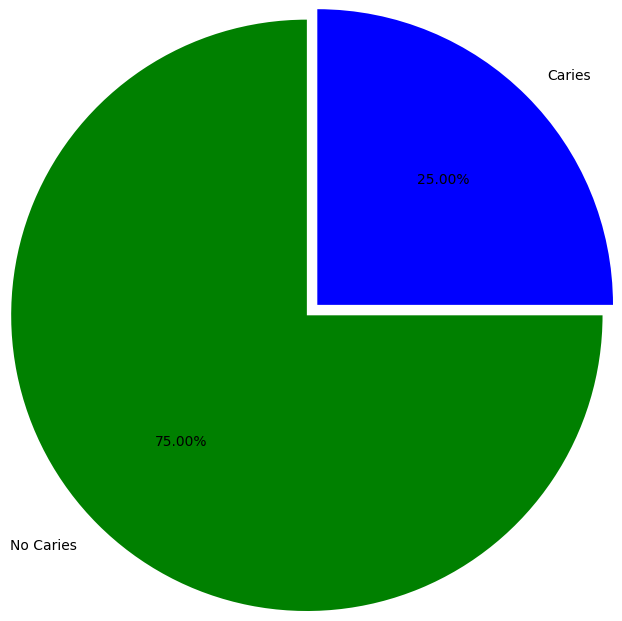

In [11]:
colors = ['green','blue']
plt.pie(data.label.value_counts(),startangle=90,explode=[0.05,0.05],autopct='%0.2f%%',labels=['No Caries', 'Caries'], colors= colors,radius=2)
plt.show()

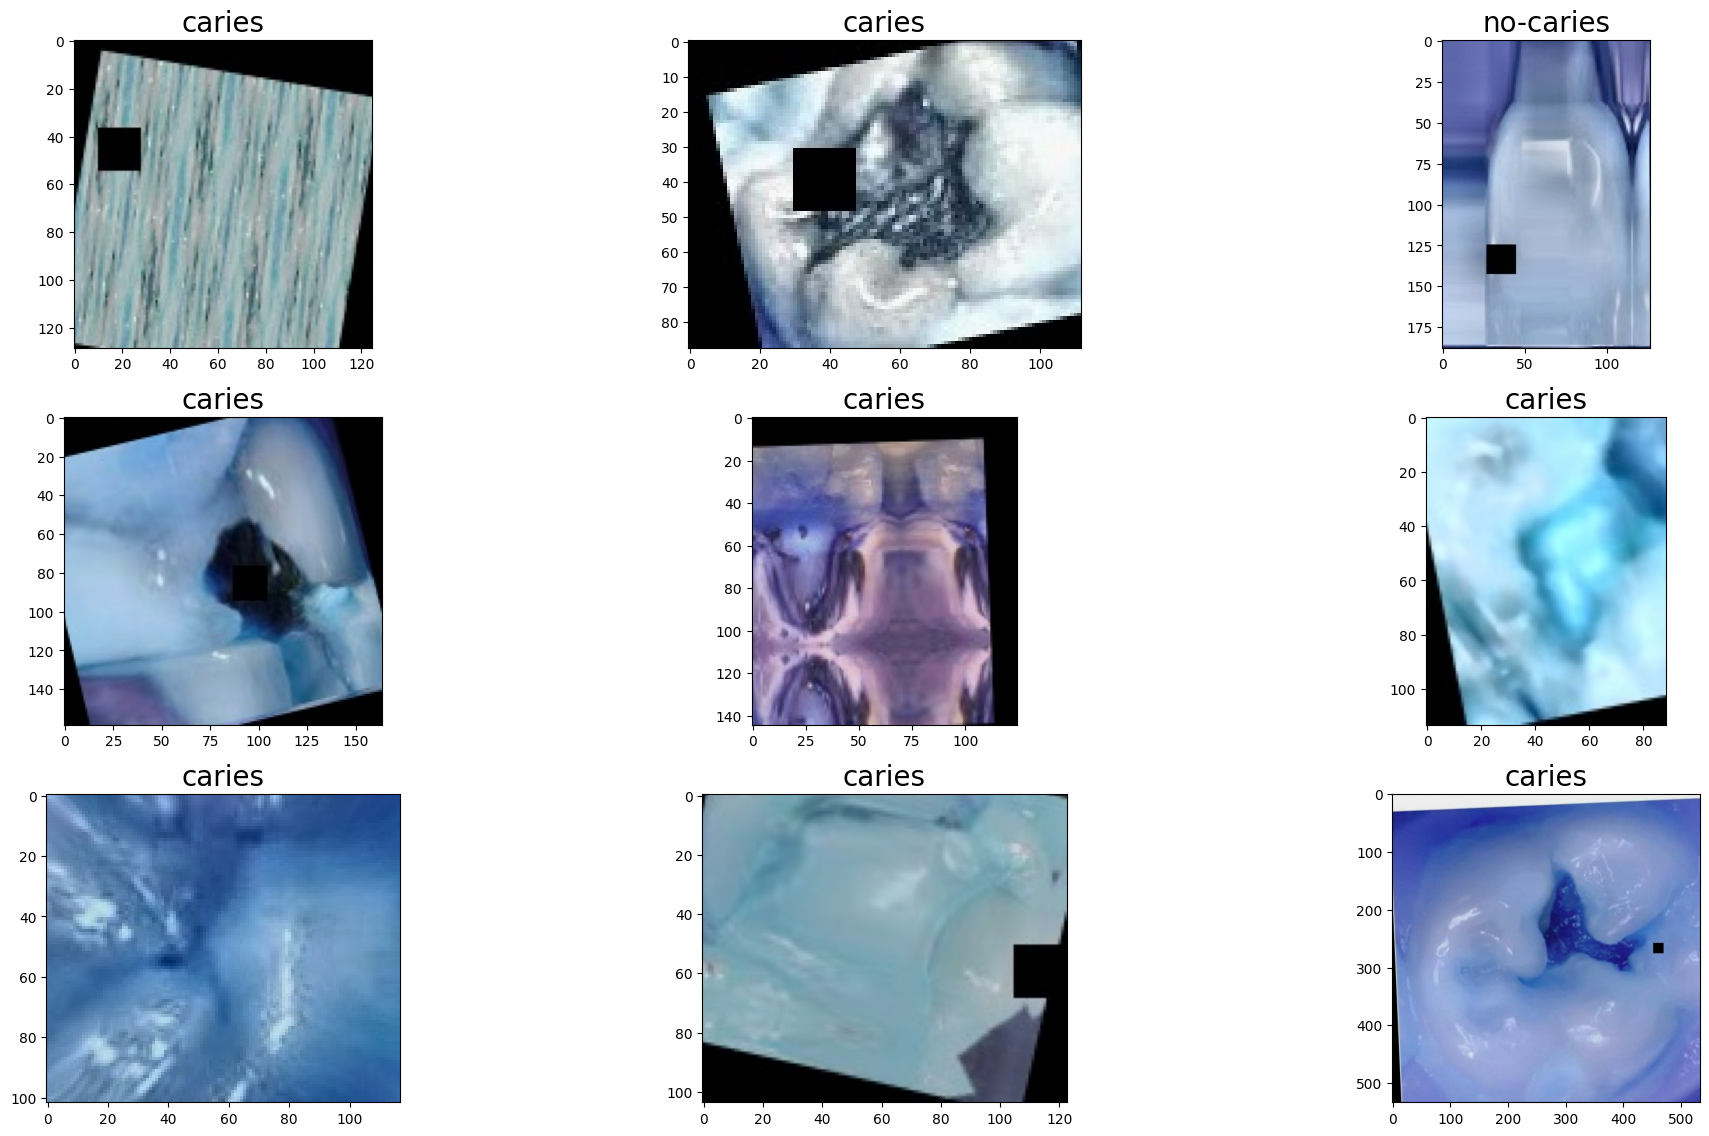

In [12]:
plt.figure(figsize=(20,15))
for i in range(9):
    plt.subplot(4,3,(i%12)+1)
    index=np.random.randint(1000)
    plt.title('{0}'.format(data.label[index]),fontdict={'size':20})
    plt.imshow(data.image[index])
    plt.tight_layout()

In [13]:
className = glob(train_path + '/*' )
numberOfClass = len(className)
print("Number Of Class: ",numberOfClass)

Number Of Class:  2


## Getting contents of testing data

In [14]:
x_data = [] 
y_data = [] 

for category in glob(test_path+'/*'):
    for file in tqdm(glob(category+'/*')):
        img_array=cv2.imread(file)
        img_array = cv2.cvtColor(img_array, cv2.COLOR_BGR2RGB)
        x_data.append(img_array) 
        y_data.append(category.split("/")[-1])
        
data=pd.DataFrame({'image': x_data,'label': y_data})

100%|██████████| 84/84 [00:00<00:00, 3198.15it/s]


In [15]:
data.shape

(294, 2)

In [16]:
from collections import Counter
Counter(y_data)

Counter({'caries': 210, 'no-caries': 84})

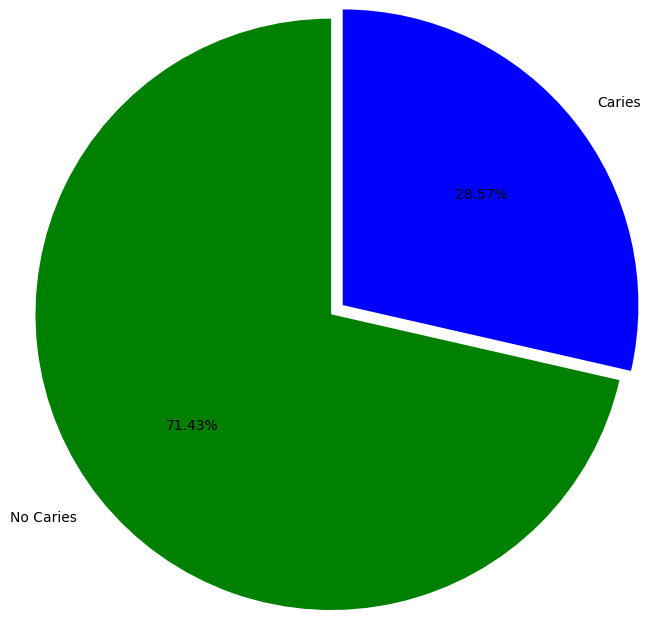

In [17]:
colors = ['green','blue']
plt.pie(data.label.value_counts(),startangle=90,explode=[0.05,0.05],autopct='%0.2f%%',labels=['No Caries', 'Caries'], colors= colors,radius=2)
plt.show()

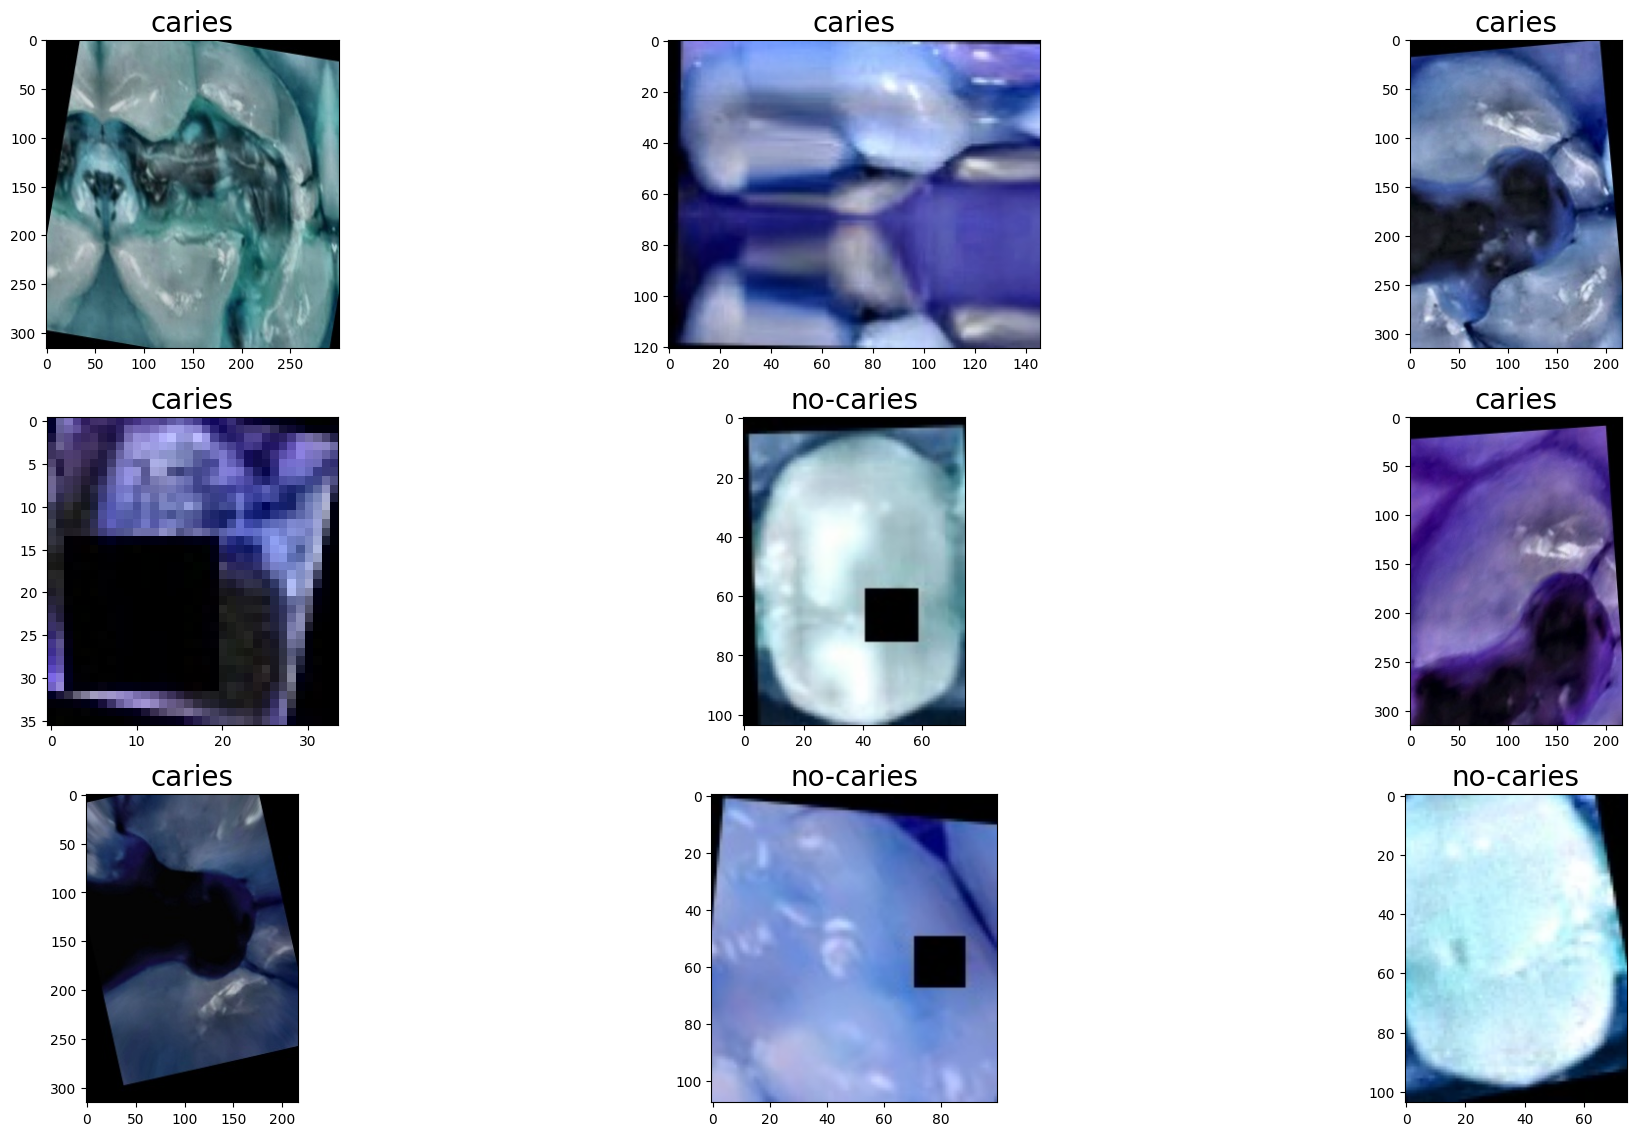

In [18]:
plt.figure(figsize=(20,15))
for i in range(9):
    plt.subplot(4,3,(i%12)+1)
    index=np.random.randint(294)
    plt.title('{0}'.format(data.label[index]),fontdict={'size':20})
    plt.imshow(data.image[index])
    plt.tight_layout()

## Model Building

### Image Augmentation

In [28]:
train_generator = ImageDataGenerator( 
    rescale = 1.0/255.,
    rotation_range=30,
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=0.1,
    zoom_range=0.1,
    horizontal_flip=True,
    vertical_flip=True,
    fill_mode='nearest',
    brightness_range=(0.5, 1.5),
)
test_generator = ImageDataGenerator(rescale=1./255.)


In [86]:
train_datagen = train_generator.flow_from_directory(
    train_path, 
    batch_size=10,
    target_size=(96, 96)
)
test_datagen = test_generator.flow_from_directory(
    test_path, 
    batch_size=10,
    target_size=(96, 96)
)

Found 1260 images belonging to 2 classes.
Found 294 images belonging to 2 classes.


### Proposed CNN Model

In [30]:
model = Sequential()

model.add(Conv2D(32, (3, 3), activation='relu', input_shape=(96, 96, 3)))
model.add(MaxPooling2D((2, 2)))

model.add(Conv2D(96, (3, 3), activation='relu'))
model.add(MaxPooling2D((2, 2)))

model.add(Conv2D(128, (3, 3), activation='relu'))
model.add(MaxPooling2D((2, 2)))

model.add(Conv2D(128, (3, 3), activation='relu'))
model.add(MaxPooling2D((2, 2)))

model.add(Flatten())
model.add(Dense(512, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(2, activation='softmax'))

model.compile(loss='binary_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

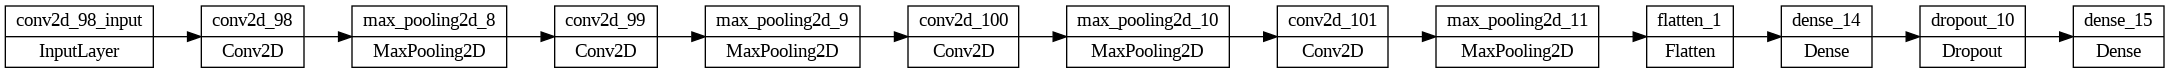

In [31]:
plot_model(model, rankdir = "LR")

In [32]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_98 (Conv2D)          (None, 94, 94, 32)        896       
                                                                 
 max_pooling2d_8 (MaxPooling  (None, 47, 47, 32)       0         
 2D)                                                             
                                                                 
 conv2d_99 (Conv2D)          (None, 45, 45, 96)        27744     
                                                                 
 max_pooling2d_9 (MaxPooling  (None, 22, 22, 96)       0         
 2D)                                                             
                                                                 
 conv2d_100 (Conv2D)         (None, 20, 20, 128)       110720    
                                                                 
 max_pooling2d_10 (MaxPoolin  (None, 10, 10, 128)     

In [33]:
hist_cnn = model.fit_generator(generator = train_datagen,epochs=20,validation_data = test_datagen)

Epoch 1/20
126/126 [==============================] - 10s 54ms/step - loss: 0.6113 - accuracy: 0.7500 - val_loss: 0.4082 - val_accuracy: 0.7143
Epoch 2/20
126/126 [==============================] - 6s 44ms/step - loss: 0.5036 - accuracy: 0.7603 - val_loss: 0.4110 - val_accuracy: 0.7211
Epoch 3/20
126/126 [==============================] - 6s 48ms/step - loss: 0.4584 - accuracy: 0.7833 - val_loss: 0.4238 - val_accuracy: 0.7245
Epoch 4/20
126/126 [==============================] - 5s 43ms/step - loss: 0.4818 - accuracy: 0.7722 - val_loss: 0.3622 - val_accuracy: 0.8231
Epoch 5/20
126/126 [==============================] - 6s 50ms/step - loss: 0.4451 - accuracy: 0.7937 - val_loss: 0.3510 - val_accuracy: 0.8027
Epoch 6/20
126/126 [==============================] - 5s 43ms/step - loss: 0.4317 - accuracy: 0.7913 - val_loss: 0.3611 - val_accuracy: 0.8333
Epoch 7/20
126/126 [==============================] - 6s 51ms/step - loss: 0.4513 - accuracy: 0.7873 - val_loss: 0.3846 - val_accuracy: 0.812

## Transfer Learning

### ResNet101V2

In [87]:
from tensorflow.keras.layers import Dense, Flatten, Dropout, GlobalAveragePooling2D
from tensorflow.keras.models import Model
from tensorflow.keras.applications.resnet_v2 import ResNet101V2

base_model = ResNet101V2(weights='imagenet', include_top=False, input_shape=(96, 96, 3))

# Freeze pre-trained layers
for layer in base_model.layers:
    layer.trainable = False

x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(512, activation='relu')(x)
x = Dropout(0.5)(x)
x = Dense(256, activation='relu')(x)
x = Dropout(0.5)(x)
x = Dense(128, activation='relu')(x)
x = Dropout(0.5)(x)
predictions = Dense(2, activation='softmax')(x)

model_res = Model(inputs=base_model.input, outputs=predictions)

model_res.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
hist_res = model_res.fit(train_datagen, epochs=10, validation_data=test_datagen)

171317808/171317808 [==============================] - 1s 0us/step
Epoch 1/10
126/126 [==============================] - 16s 69ms/step - loss: 0.7797 - accuracy: 0.7310 - val_loss: 0.4149 - val_accuracy: 0.8231
Epoch 2/10
126/126 [==============================] - 7s 59ms/step - loss: 0.5263 - accuracy: 0.7730 - val_loss: 0.3823 - val_accuracy: 0.8129
Epoch 3/10
126/126 [==============================] - 6s 51ms/step - loss: 0.4830 - accuracy: 0.7825 - val_loss: 0.3194 - val_accuracy: 0.9082
Epoch 4/10
126/126 [==============================] - 7s 58ms/step - loss: 0.4159 - accuracy: 0.8222 - val_loss: 0.2996 - val_accuracy: 0.8673
Epoch 5/10
126/126 [==============================] - 7s 59ms/step - loss: 0.4094 - accuracy: 0.8230 - val_loss: 0.3145 - val_accuracy: 0.8537
Epoch 6/10
126/126 [==============================] - 6s 50ms/step - loss: 0.3815 - accuracy: 0.8357 - val_loss: 0.3319 - val_accuracy: 0.8503
Epoch 7/10
126/126 [==============================] - 7s 58ms/step - loss:

### InceptionV3

In [35]:
from tensorflow.keras.layers import Dense, Flatten, Dropout, GlobalAveragePooling2D, MaxPooling2D
from tensorflow.keras.models import Model
from tensorflow.keras.applications.inception_v3 import InceptionV3

base_model = InceptionV3(weights='imagenet', include_top=False, input_shape=(96, 96, 3))

# Freeze pre-trained layers
for layer in base_model.layers:
    layer.trainable = False


x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(512, activation='relu')(x)
x = Dropout(0.5)(x)
x = Dense(256, activation='relu')(x)
x = Dropout(0.5)(x)
x = Dense(128, activation='relu')(x)
x = Dropout(0.5)(x)
predictions = Dense(2, activation='softmax')(x)

model_inc = Model(inputs=base_model.input, outputs=predictions)

model_inc.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
hist_inc = model_inc.fit(train_datagen, epochs=10, validation_data=test_datagen)

Epoch 1/10
126/126 [==============================] - 14s 62ms/step - loss: 0.7880 - accuracy: 0.7198 - val_loss: 0.5326 - val_accuracy: 0.7143
Epoch 2/10
126/126 [==============================] - 7s 54ms/step - loss: 0.5633 - accuracy: 0.7532 - val_loss: 0.4923 - val_accuracy: 0.7619
Epoch 3/10
126/126 [==============================] - 6s 46ms/step - loss: 0.4905 - accuracy: 0.7762 - val_loss: 0.4689 - val_accuracy: 0.7857
Epoch 4/10
126/126 [==============================] - 7s 56ms/step - loss: 0.4944 - accuracy: 0.7810 - val_loss: 0.4779 - val_accuracy: 0.7619
Epoch 5/10
126/126 [==============================] - 7s 56ms/step - loss: 0.4625 - accuracy: 0.7873 - val_loss: 0.4735 - val_accuracy: 0.7755
Epoch 6/10
126/126 [==============================] - 6s 49ms/step - loss: 0.4647 - accuracy: 0.7976 - val_loss: 0.4552 - val_accuracy: 0.7721
Epoch 7/10
126/126 [==============================] - 7s 54ms/step - loss: 0.4408 - accuracy: 0.8032 - val_loss: 0.4656 - val_accuracy: 0.778

### MobileNetV2

In [36]:
from tensorflow.keras.layers import Dense, Flatten, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.applications.mobilenet_v2 import MobileNetV2

base_model = MobileNetV2(weights='imagenet', include_top=False, input_shape=(96, 96, 3))

# Freeze pre-trained layers
for layer in base_model.layers:
    layer.trainable = False

x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(512, activation='relu')(x)
x = Dropout(0.5)(x)
x = Dense(256, activation='relu')(x)
x = Dropout(0.5)(x)
x = Dense(128, activation='relu')(x)
x = Dropout(0.5)(x)
predictions = Dense(2, activation='softmax')(x)

model_mob = Model(inputs=base_model.input, outputs=predictions)

model_mob.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
hist_mob = model_mob.fit(train_datagen, epochs=10, validation_data=test_datagen)

9406464/9406464 [==============================] - 0s 0us/step
Epoch 1/10
126/126 [==============================] - 11s 58ms/step - loss: 0.6636 - accuracy: 0.7516 - val_loss: 0.3971 - val_accuracy: 0.8571
Epoch 2/10
126/126 [==============================] - 5s 43ms/step - loss: 0.4632 - accuracy: 0.8008 - val_loss: 0.4072 - val_accuracy: 0.7959
Epoch 3/10
126/126 [==============================] - 6s 51ms/step - loss: 0.3845 - accuracy: 0.8286 - val_loss: 0.3678 - val_accuracy: 0.8299
Epoch 4/10
126/126 [==============================] - 5s 43ms/step - loss: 0.4134 - accuracy: 0.8230 - val_loss: 0.4336 - val_accuracy: 0.7993
Epoch 5/10
126/126 [==============================] - 7s 52ms/step - loss: 0.3876 - accuracy: 0.8317 - val_loss: 0.3672 - val_accuracy: 0.8163
Epoch 6/10
126/126 [==============================] - 6s 45ms/step - loss: 0.3600 - accuracy: 0.8262 - val_loss: 0.3409 - val_accuracy: 0.8707
Epoch 7/10
126/126 [==============================] - 7s 52ms/step - loss: 0.3

### VGG16

In [37]:
from tensorflow.keras.layers import Dense, Flatten, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.applications.vgg16 import VGG16

base_model = VGG16(weights='imagenet', include_top=False, input_shape=(48, 48, 3))

# Freeze pre-trained layers
for layer in base_model.layers:
    layer.trainable = False

x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(512, activation='relu')(x)
x = Dropout(0.5)(x)
x = Dense(256, activation='relu')(x)
x = Dropout(0.5)(x)
x = Dense(128, activation='relu')(x)
x = Dropout(0.5)(x)
predictions = Dense(2, activation='softmax')(x)

model_vgg = Model(inputs=base_model.input, outputs=predictions)

model_vgg.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
hist_vgg = model_vgg.fit(train_datagen, epochs=10, validation_data=test_datagen)

58889256/58889256 [==============================] - 0s 0us/step
Epoch 1/10
126/126 [==============================] - 10s 51ms/step - loss: 0.5780 - accuracy: 0.7341 - val_loss: 0.4630 - val_accuracy: 0.7483
Epoch 2/10
126/126 [==============================] - 7s 54ms/step - loss: 0.4666 - accuracy: 0.7992 - val_loss: 0.4410 - val_accuracy: 0.7857
Epoch 3/10
126/126 [==============================] - 7s 54ms/step - loss: 0.4266 - accuracy: 0.8063 - val_loss: 0.4348 - val_accuracy: 0.8197
Epoch 4/10
126/126 [==============================] - 6s 49ms/step - loss: 0.4112 - accuracy: 0.8151 - val_loss: 0.4649 - val_accuracy: 0.7585
Epoch 5/10
126/126 [==============================] - 6s 50ms/step - loss: 0.4099 - accuracy: 0.8135 - val_loss: 0.4485 - val_accuracy: 0.8129
Epoch 6/10
126/126 [==============================] - 6s 50ms/step - loss: 0.3905 - accuracy: 0.8246 - val_loss: 0.4471 - val_accuracy: 0.7993
Epoch 7/10
126/126 [==============================] - 6s 48ms/step - loss: 0

## Different Image Size

In [88]:
train_datagen = train_generator.flow_from_directory(
    train_path, 
    batch_size=10,
    target_size=(128, 128)
)
test_datagen = test_generator.flow_from_directory(
    test_path, 
    batch_size=10,
    target_size=(128, 128)
)

Found 1260 images belonging to 2 classes.
Found 294 images belonging to 2 classes.


### Proposed CNN Model

In [39]:
model = Sequential()

model.add(Conv2D(32, (3, 3), activation='relu', input_shape=(128, 128, 3)))
model.add(MaxPooling2D((2, 2)))

model.add(Conv2D(96, (3, 3), activation='relu'))
model.add(MaxPooling2D((2, 2)))

model.add(Conv2D(128, (3, 3), activation='relu'))
model.add(MaxPooling2D((2, 2)))

model.add(Conv2D(128, (3, 3), activation='relu'))
model.add(MaxPooling2D((2, 2)))

model.add(Flatten())
model.add(Dense(512, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(2, activation='softmax'))

model.compile(loss='binary_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

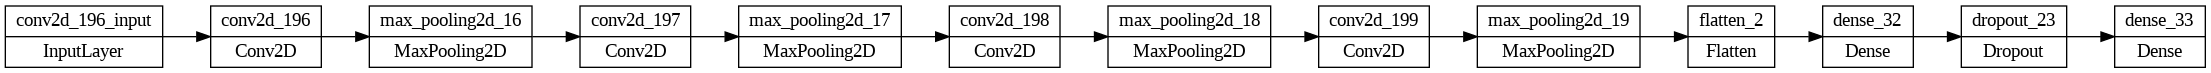

In [40]:
plot_model(model, rankdir = "LR")

In [41]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_196 (Conv2D)         (None, 126, 126, 32)      896       
                                                                 
 max_pooling2d_16 (MaxPoolin  (None, 63, 63, 32)       0         
 g2D)                                                            
                                                                 
 conv2d_197 (Conv2D)         (None, 61, 61, 96)        27744     
                                                                 
 max_pooling2d_17 (MaxPoolin  (None, 30, 30, 96)       0         
 g2D)                                                            
                                                                 
 conv2d_198 (Conv2D)         (None, 28, 28, 128)       110720    
                                                                 
 max_pooling2d_18 (MaxPoolin  (None, 14, 14, 128)     

In [42]:
hist_cnn2 = model.fit_generator(generator = train_datagen,epochs=20,validation_data = test_datagen)

Epoch 1/20
126/126 [==============================] - 11s 69ms/step - loss: 0.5901 - accuracy: 0.7460 - val_loss: 0.8570 - val_accuracy: 0.7143
Epoch 2/20
126/126 [==============================] - 8s 62ms/step - loss: 0.5528 - accuracy: 0.7500 - val_loss: 0.4148 - val_accuracy: 0.7143
Epoch 3/20
126/126 [==============================] - 8s 60ms/step - loss: 0.5390 - accuracy: 0.7492 - val_loss: 0.3749 - val_accuracy: 0.7143
Epoch 4/20
126/126 [==============================] - 8s 67ms/step - loss: 0.5204 - accuracy: 0.7595 - val_loss: 0.5131 - val_accuracy: 0.7143
Epoch 5/20
126/126 [==============================] - 8s 67ms/step - loss: 0.4826 - accuracy: 0.7627 - val_loss: 0.3285 - val_accuracy: 0.8095
Epoch 6/20
126/126 [==============================] - 8s 62ms/step - loss: 0.4609 - accuracy: 0.7738 - val_loss: 0.3575 - val_accuracy: 0.8027
Epoch 7/20
126/126 [==============================] - 8s 60ms/step - loss: 0.4356 - accuracy: 0.7817 - val_loss: 0.3523 - val_accuracy: 0.806

## Transfer Learning

### ResNet101V2

In [89]:
from tensorflow.keras.layers import Dense, Flatten, Dropout, GlobalAveragePooling2D
from tensorflow.keras.models import Model
from tensorflow.keras.applications.resnet_v2 import ResNet101V2

base_model = ResNet101V2(weights='imagenet', include_top=False, input_shape=(128, 128, 3))

# Freeze pre-trained layers
for layer in base_model.layers:
    layer.trainable = False

x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(512, activation='relu')(x)
x = Dropout(0.5)(x)
x = Dense(256, activation='relu')(x)
x = Dropout(0.5)(x)
x = Dense(128, activation='relu')(x)
x = Dropout(0.5)(x)
predictions = Dense(2, activation='softmax')(x)

model_res = Model(inputs=base_model.input, outputs=predictions)

model_res.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
hist_res2 = model_res.fit(train_datagen, epochs=10, validation_data=test_datagen)

Epoch 1/10
126/126 [==============================] - 19s 91ms/step - loss: 0.7239 - accuracy: 0.7476 - val_loss: 0.4062 - val_accuracy: 0.7823
Epoch 2/10
126/126 [==============================] - 9s 74ms/step - loss: 0.5162 - accuracy: 0.7865 - val_loss: 0.3854 - val_accuracy: 0.8129
Epoch 3/10
126/126 [==============================] - 9s 68ms/step - loss: 0.4342 - accuracy: 0.8175 - val_loss: 0.3159 - val_accuracy: 0.8605
Epoch 4/10
126/126 [==============================] - 9s 71ms/step - loss: 0.4193 - accuracy: 0.8214 - val_loss: 0.3409 - val_accuracy: 0.8435
Epoch 5/10
126/126 [==============================] - 9s 75ms/step - loss: 0.3760 - accuracy: 0.8413 - val_loss: 0.3263 - val_accuracy: 0.8333
Epoch 6/10
126/126 [==============================] - 9s 75ms/step - loss: 0.3696 - accuracy: 0.8325 - val_loss: 0.2940 - val_accuracy: 0.8503
Epoch 7/10
126/126 [==============================] - 9s 71ms/step - loss: 0.3809 - accuracy: 0.8310 - val_loss: 0.3264 - val_accuracy: 0.829

### InceptionV3

In [44]:
from tensorflow.keras.layers import Dense, Flatten, Dropout, GlobalAveragePooling2D, MaxPooling2D
from tensorflow.keras.models import Model
from tensorflow.keras.applications.inception_v3 import InceptionV3

base_model = InceptionV3(weights='imagenet', include_top=False, input_shape=(192, 192, 3))

# Freeze pre-trained layers
for layer in base_model.layers:
    layer.trainable = False


x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(512, activation='relu')(x)
x = Dropout(0.5)(x)
x = Dense(256, activation='relu')(x)
x = Dropout(0.5)(x)
x = Dense(128, activation='relu')(x)
x = Dropout(0.5)(x)
predictions = Dense(2, activation='softmax')(x)

model_inc = Model(inputs=base_model.input, outputs=predictions)

model_inc.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
hist_inc2 = model_inc.fit(train_datagen, epochs=10, validation_data=test_datagen)

Epoch 1/10
126/126 [==============================] - 18s 90ms/step - loss: 1.0805 - accuracy: 0.7024 - val_loss: 0.5716 - val_accuracy: 0.7211
Epoch 2/10
126/126 [==============================] - 9s 72ms/step - loss: 0.5423 - accuracy: 0.7659 - val_loss: 0.5667 - val_accuracy: 0.7177
Epoch 3/10
126/126 [==============================] - 9s 72ms/step - loss: 0.5207 - accuracy: 0.7770 - val_loss: 0.4637 - val_accuracy: 0.7619
Epoch 4/10
126/126 [==============================] - 9s 72ms/step - loss: 0.4877 - accuracy: 0.7762 - val_loss: 0.4494 - val_accuracy: 0.7687
Epoch 5/10
126/126 [==============================] - 8s 66ms/step - loss: 0.4892 - accuracy: 0.7944 - val_loss: 0.4575 - val_accuracy: 0.7789
Epoch 6/10
126/126 [==============================] - 9s 71ms/step - loss: 0.4400 - accuracy: 0.8079 - val_loss: 0.4356 - val_accuracy: 0.7619
Epoch 7/10
126/126 [==============================] - 9s 74ms/step - loss: 0.4052 - accuracy: 0.8381 - val_loss: 0.4113 - val_accuracy: 0.799

### MobileNetV2

In [45]:
from tensorflow.keras.layers import Dense, Flatten, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.applications.mobilenet_v2 import MobileNetV2

base_model = MobileNetV2(weights='imagenet', include_top=False, input_shape=(128, 128, 3))

# Freeze pre-trained layers
for layer in base_model.layers:
    layer.trainable = False

x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(512, activation='relu')(x)
x = Dropout(0.5)(x)
x = Dense(256, activation='relu')(x)
x = Dropout(0.5)(x)
x = Dense(128, activation='relu')(x)
x = Dropout(0.5)(x)
predictions = Dense(2, activation='softmax')(x)

model_mob = Model(inputs=base_model.input, outputs=predictions)

model_mob.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
hist_mob2 = model_mob.fit(train_datagen, epochs=10, validation_data=test_datagen)

9406464/9406464 [==============================] - 0s 0us/step
Epoch 1/10
126/126 [==============================] - 14s 75ms/step - loss: 0.6779 - accuracy: 0.7230 - val_loss: 0.4691 - val_accuracy: 0.7585
Epoch 2/10
126/126 [==============================] - 8s 65ms/step - loss: 0.4482 - accuracy: 0.8024 - val_loss: 0.4217 - val_accuracy: 0.8027
Epoch 3/10
126/126 [==============================] - 8s 67ms/step - loss: 0.4304 - accuracy: 0.8048 - val_loss: 0.4085 - val_accuracy: 0.7993
Epoch 4/10
126/126 [==============================] - 8s 61ms/step - loss: 0.3990 - accuracy: 0.8310 - val_loss: 0.3799 - val_accuracy: 0.8095
Epoch 5/10
126/126 [==============================] - 9s 67ms/step - loss: 0.3702 - accuracy: 0.8405 - val_loss: 0.4189 - val_accuracy: 0.8061
Epoch 6/10
126/126 [==============================] - 8s 67ms/step - loss: 0.3863 - accuracy: 0.8381 - val_loss: 0.4490 - val_accuracy: 0.7755
Epoch 7/10
126/126 [==============================] - 9s 72ms/step - loss: 0.3

### VGG16

In [46]:
from tensorflow.keras.layers import Dense, Flatten, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.applications.vgg16 import VGG16

base_model = VGG16(weights='imagenet', include_top=False, input_shape=(128, 128, 3))

# Freeze pre-trained layers
for layer in base_model.layers:
    layer.trainable = False

x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(512, activation='relu')(x)
x = Dropout(0.5)(x)
x = Dense(256, activation='relu')(x)
x = Dropout(0.5)(x)
x = Dense(128, activation='relu')(x)
x = Dropout(0.5)(x)
predictions = Dense(2, activation='softmax')(x)

model_vgg = Model(inputs=base_model.input, outputs=predictions)

model_vgg.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
hist_vgg2 = model_vgg.fit(train_datagen, epochs=10, validation_data=test_datagen)

Epoch 1/10
126/126 [==============================] - 12s 77ms/step - loss: 0.5809 - accuracy: 0.7484 - val_loss: 0.4941 - val_accuracy: 0.7143
Epoch 2/10
126/126 [==============================] - 8s 65ms/step - loss: 0.4837 - accuracy: 0.7746 - val_loss: 0.4486 - val_accuracy: 0.7551
Epoch 3/10
126/126 [==============================] - 9s 71ms/step - loss: 0.4060 - accuracy: 0.8048 - val_loss: 0.4257 - val_accuracy: 0.8163
Epoch 4/10
126/126 [==============================] - 9s 71ms/step - loss: 0.4328 - accuracy: 0.8000 - val_loss: 0.4250 - val_accuracy: 0.7993
Epoch 5/10
126/126 [==============================] - 9s 74ms/step - loss: 0.3786 - accuracy: 0.8317 - val_loss: 0.4035 - val_accuracy: 0.8367
Epoch 6/10
126/126 [==============================] - 8s 64ms/step - loss: 0.3780 - accuracy: 0.8357 - val_loss: 0.3875 - val_accuracy: 0.8265
Epoch 7/10
126/126 [==============================] - 9s 72ms/step - loss: 0.3815 - accuracy: 0.8286 - val_loss: 0.4036 - val_accuracy: 0.806

## Different Image Size

In [90]:
train_datagen = train_generator.flow_from_directory(
    train_path, 
    batch_size=10,
    target_size=(192, 192)
)
test_datagen = test_generator.flow_from_directory(
    test_path, 
    batch_size=10,
    target_size=(192, 192)
)

Found 1260 images belonging to 2 classes.
Found 294 images belonging to 2 classes.


### Proposed CNN Model

In [48]:
model = Sequential()

model.add(Conv2D(32, (3, 3), activation='relu', input_shape=(192, 192, 3)))
model.add(MaxPooling2D((2, 2)))

model.add(Conv2D(96, (3, 3), activation='relu'))
model.add(MaxPooling2D((2, 2)))

model.add(Conv2D(128, (3, 3), activation='relu'))
model.add(MaxPooling2D((2, 2)))

model.add(Conv2D(128, (3, 3), activation='relu'))
model.add(MaxPooling2D((2, 2)))

model.add(Flatten())
model.add(Dense(512, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(2, activation='softmax'))

model.compile(loss='binary_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

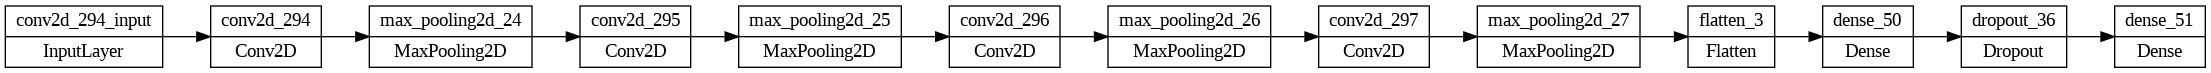

In [49]:
plot_model(model, rankdir = "LR")

In [50]:
model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_294 (Conv2D)         (None, 190, 190, 32)      896       
                                                                 
 max_pooling2d_24 (MaxPoolin  (None, 95, 95, 32)       0         
 g2D)                                                            
                                                                 
 conv2d_295 (Conv2D)         (None, 93, 93, 96)        27744     
                                                                 
 max_pooling2d_25 (MaxPoolin  (None, 46, 46, 96)       0         
 g2D)                                                            
                                                                 
 conv2d_296 (Conv2D)         (None, 44, 44, 128)       110720    
                                                                 
 max_pooling2d_26 (MaxPoolin  (None, 22, 22, 128)     

In [51]:
hist_cnn3 = model.fit_generator(generator = train_datagen,epochs=20,validation_data = test_datagen)

Epoch 1/20
126/126 [==============================] - 18s 120ms/step - loss: 0.5848 - accuracy: 0.7452 - val_loss: 0.5731 - val_accuracy: 0.7143
Epoch 2/20
126/126 [==============================] - 14s 112ms/step - loss: 0.5532 - accuracy: 0.7484 - val_loss: 0.5037 - val_accuracy: 0.7143
Epoch 3/20
126/126 [==============================] - 14s 113ms/step - loss: 0.4962 - accuracy: 0.7587 - val_loss: 0.4184 - val_accuracy: 0.7245
Epoch 4/20
126/126 [==============================] - 14s 111ms/step - loss: 0.4623 - accuracy: 0.7794 - val_loss: 0.3705 - val_accuracy: 0.7483
Epoch 5/20
126/126 [==============================] - 14s 111ms/step - loss: 0.4591 - accuracy: 0.7571 - val_loss: 0.4126 - val_accuracy: 0.7143
Epoch 6/20
126/126 [==============================] - 14s 112ms/step - loss: 0.4816 - accuracy: 0.7548 - val_loss: 0.4575 - val_accuracy: 0.7143
Epoch 7/20
126/126 [==============================] - 14s 114ms/step - loss: 0.4721 - accuracy: 0.7675 - val_loss: 0.3542 - val_ac

## Transfer Learning

### ResNet101V2

In [91]:
from tensorflow.keras.layers import Dense, Flatten, Dropout, GlobalAveragePooling2D
from tensorflow.keras.models import Model
from tensorflow.keras.applications.resnet_v2 import ResNet101V2

base_model = ResNet101V2(weights='imagenet', include_top=False, input_shape=(192, 192, 3))

# Freeze pre-trained layers
for layer in base_model.layers:
    layer.trainable = False

x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(512, activation='relu')(x)
x = Dropout(0.5)(x)
x = Dense(256, activation='relu')(x)
x = Dropout(0.5)(x)
x = Dense(128, activation='relu')(x)
x = Dropout(0.5)(x)
predictions = Dense(2, activation='softmax')(x)

model_res = Model(inputs=base_model.input, outputs=predictions)

model_res.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
hist_res3 = model_res.fit(train_datagen, epochs=10, validation_data=test_datagen)

Epoch 1/10
126/126 [==============================] - 26s 149ms/step - loss: 0.6137 - accuracy: 0.7476 - val_loss: 0.3970 - val_accuracy: 0.7925
Epoch 2/10
126/126 [==============================] - 17s 134ms/step - loss: 0.4363 - accuracy: 0.8008 - val_loss: 0.3409 - val_accuracy: 0.8231
Epoch 3/10
126/126 [==============================] - 16s 131ms/step - loss: 0.3775 - accuracy: 0.8365 - val_loss: 0.3792 - val_accuracy: 0.8027
Epoch 4/10
126/126 [==============================] - 16s 128ms/step - loss: 0.3444 - accuracy: 0.8516 - val_loss: 0.3004 - val_accuracy: 0.8537
Epoch 5/10
126/126 [==============================] - 16s 127ms/step - loss: 0.3429 - accuracy: 0.8468 - val_loss: 0.3488 - val_accuracy: 0.8129
Epoch 6/10
126/126 [==============================] - 16s 127ms/step - loss: 0.3168 - accuracy: 0.8571 - val_loss: 0.3773 - val_accuracy: 0.8027
Epoch 7/10
126/126 [==============================] - 17s 133ms/step - loss: 0.3207 - accuracy: 0.8706 - val_loss: 0.3157 - val_ac

### InceptionV3

In [53]:
from tensorflow.keras.layers import Dense, Flatten, Dropout, GlobalAveragePooling2D, MaxPooling2D
from tensorflow.keras.models import Model
from tensorflow.keras.applications.inception_v3 import InceptionV3

base_model = InceptionV3(weights='imagenet', include_top=False, input_shape=(192, 192, 3))

# Freeze pre-trained layers
for layer in base_model.layers:
    layer.trainable = False


x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(512, activation='relu')(x)
x = Dropout(0.5)(x)
x = Dense(256, activation='relu')(x)
x = Dropout(0.5)(x)
x = Dense(128, activation='relu')(x)
x = Dropout(0.5)(x)
predictions = Dense(2, activation='softmax')(x)

model_inc = Model(inputs=base_model.input, outputs=predictions)

model_inc.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
hist_inc3 = model_inc.fit(train_datagen, epochs=10, validation_data=test_datagen)

Epoch 1/10
126/126 [==============================] - 25s 143ms/step - loss: 0.9555 - accuracy: 0.6794 - val_loss: 0.5720 - val_accuracy: 0.7143
Epoch 2/10
126/126 [==============================] - 16s 125ms/step - loss: 0.5710 - accuracy: 0.7413 - val_loss: 0.4813 - val_accuracy: 0.7891
Epoch 3/10
126/126 [==============================] - 15s 119ms/step - loss: 0.5059 - accuracy: 0.7754 - val_loss: 0.4359 - val_accuracy: 0.7823
Epoch 4/10
126/126 [==============================] - 15s 119ms/step - loss: 0.4515 - accuracy: 0.7849 - val_loss: 0.4002 - val_accuracy: 0.8265
Epoch 5/10
126/126 [==============================] - 15s 119ms/step - loss: 0.4174 - accuracy: 0.8040 - val_loss: 0.4079 - val_accuracy: 0.7959
Epoch 6/10
126/126 [==============================] - 16s 127ms/step - loss: 0.4195 - accuracy: 0.8230 - val_loss: 0.4246 - val_accuracy: 0.7755
Epoch 7/10
126/126 [==============================] - 15s 118ms/step - loss: 0.4197 - accuracy: 0.8238 - val_loss: 0.4196 - val_ac

### MobileNetV2

In [54]:
from tensorflow.keras.layers import Dense, Flatten, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.applications.mobilenet_v2 import MobileNetV2

base_model = MobileNetV2(weights='imagenet', include_top=False, input_shape=(192, 192, 3))

# Freeze pre-trained layers
for layer in base_model.layers:
    layer.trainable = False

x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(512, activation='relu')(x)
x = Dropout(0.5)(x)
x = Dense(256, activation='relu')(x)
x = Dropout(0.5)(x)
x = Dense(128, activation='relu')(x)
x = Dropout(0.5)(x)
predictions = Dense(2, activation='softmax')(x)

model_mob = Model(inputs=base_model.input, outputs=predictions)

model_mob.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
hist_mob3 = model_mob.fit(train_datagen, epochs=10, validation_data=test_datagen)

9406464/9406464 [==============================] - 0s 0us/step
Epoch 1/10
126/126 [==============================] - 20s 126ms/step - loss: 0.6412 - accuracy: 0.7325 - val_loss: 0.5774 - val_accuracy: 0.7551
Epoch 2/10
126/126 [==============================] - 14s 110ms/step - loss: 0.4664 - accuracy: 0.7889 - val_loss: 0.6850 - val_accuracy: 0.7347
Epoch 3/10
126/126 [==============================] - 14s 111ms/step - loss: 0.3817 - accuracy: 0.8381 - val_loss: 0.5556 - val_accuracy: 0.7551
Epoch 4/10
126/126 [==============================] - 14s 110ms/step - loss: 0.3691 - accuracy: 0.8365 - val_loss: 0.4927 - val_accuracy: 0.7823
Epoch 5/10
126/126 [==============================] - 14s 110ms/step - loss: 0.3585 - accuracy: 0.8516 - val_loss: 0.5644 - val_accuracy: 0.7585
Epoch 6/10
126/126 [==============================] - 14s 110ms/step - loss: 0.3531 - accuracy: 0.8484 - val_loss: 0.5707 - val_accuracy: 0.7721
Epoch 7/10
126/126 [==============================] - 15s 117ms/ste

### VGG16

In [55]:
from tensorflow.keras.layers import Dense, Flatten, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.applications.vgg16 import VGG16

base_model = VGG16(weights='imagenet', include_top=False, input_shape=(192, 192, 3))

# Freeze pre-trained layers
for layer in base_model.layers:
    layer.trainable = False

x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(512, activation='relu')(x)
x = Dropout(0.5)(x)
x = Dense(256, activation='relu')(x)
x = Dropout(0.5)(x)
x = Dense(128, activation='relu')(x)
x = Dropout(0.5)(x)
predictions = Dense(2, activation='softmax')(x)

model_vgg = Model(inputs=base_model.input, outputs=predictions)

model_vgg.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
hist_vgg3 = model_vgg.fit(train_datagen, epochs=10, validation_data=test_datagen)

Epoch 1/10
126/126 [==============================] - 20s 135ms/step - loss: 0.5835 - accuracy: 0.7452 - val_loss: 0.5318 - val_accuracy: 0.7143
Epoch 2/10
126/126 [==============================] - 15s 123ms/step - loss: 0.5135 - accuracy: 0.7540 - val_loss: 0.4605 - val_accuracy: 0.7313
Epoch 3/10
126/126 [==============================] - 16s 124ms/step - loss: 0.4451 - accuracy: 0.7833 - val_loss: 0.4001 - val_accuracy: 0.7755
Epoch 4/10
126/126 [==============================] - 16s 124ms/step - loss: 0.4041 - accuracy: 0.8071 - val_loss: 0.3433 - val_accuracy: 0.8639
Epoch 5/10
126/126 [==============================] - 16s 124ms/step - loss: 0.3916 - accuracy: 0.8222 - val_loss: 0.4292 - val_accuracy: 0.7755
Epoch 6/10
126/126 [==============================] - 16s 130ms/step - loss: 0.3738 - accuracy: 0.8302 - val_loss: 0.3879 - val_accuracy: 0.7891
Epoch 7/10
126/126 [==============================] - 16s 123ms/step - loss: 0.3741 - accuracy: 0.8437 - val_loss: 0.3417 - val_ac

## Different Image Size

# Model Evaluation

## Accuracy Curves

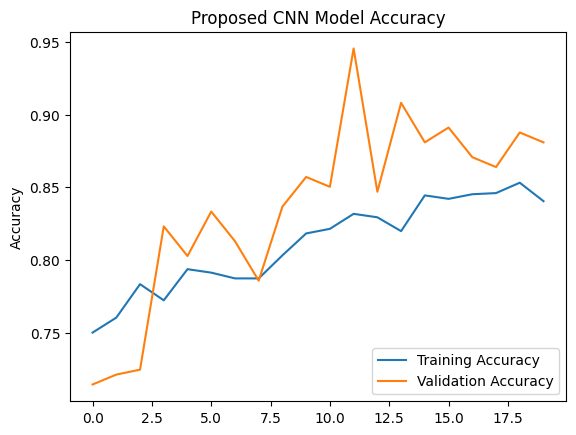

In [56]:
acc = hist_cnn.history['accuracy']
val_acc = hist_cnn.history['val_accuracy']

plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),max(plt.ylim())])
plt.title('Proposed CNN Model Accuracy')
plt.show()

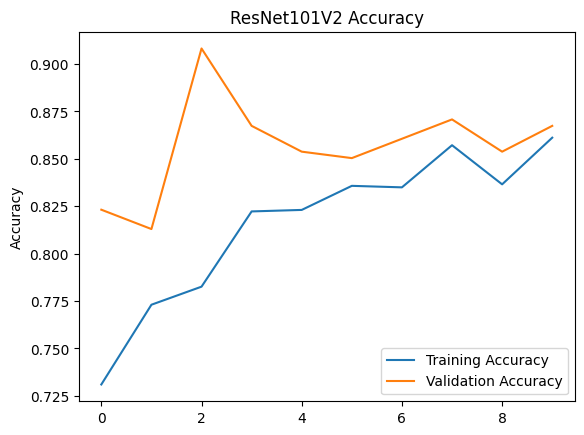

In [92]:
acc = hist_res.history['accuracy']
val_acc = hist_res.history['val_accuracy']

plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),max(plt.ylim())])
plt.title('ResNet101V2 Accuracy')
plt.show()

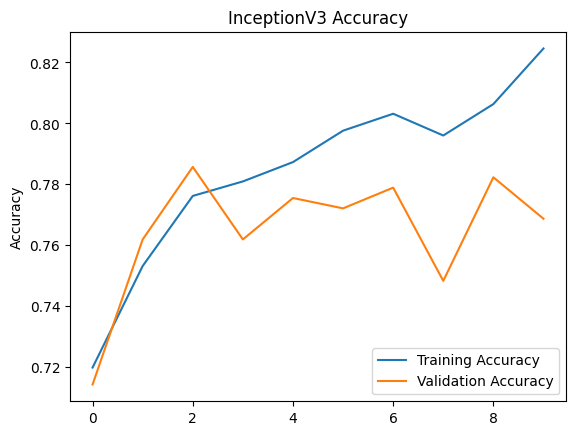

In [58]:
acc = hist_inc.history['accuracy']
val_acc = hist_inc.history['val_accuracy']

plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),max(plt.ylim())])
plt.title('InceptionV3 Accuracy')
plt.show()

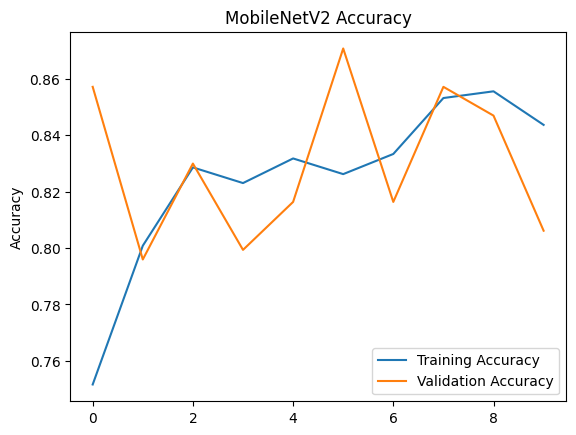

In [59]:
acc = hist_mob.history['accuracy']
val_acc = hist_mob.history['val_accuracy']

plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),max(plt.ylim())])
plt.title('MobileNetV2 Accuracy')
plt.show()

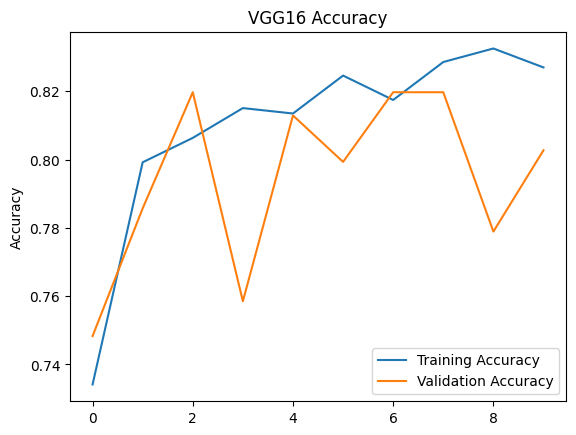

In [60]:
acc = hist_vgg.history['accuracy']
val_acc = hist_vgg.history['val_accuracy']

plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),max(plt.ylim())])
plt.title('VGG16 Accuracy')
plt.show()

## Loss Curves

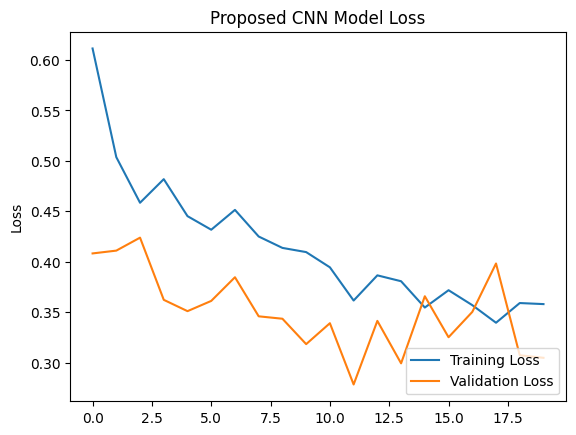

In [61]:
acc = hist_cnn.history['loss']
val_acc = hist_cnn.history['val_loss']

plt.plot(acc, label='Training Loss')
plt.plot(val_acc, label='Validation Loss')
plt.legend(loc='lower right')
plt.ylabel('Loss')
plt.ylim([min(plt.ylim()),max(plt.ylim())])
plt.title('Proposed CNN Model Loss')
plt.show()

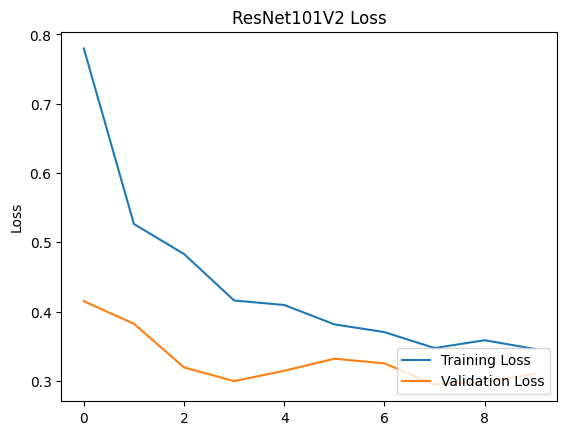

In [93]:
acc = hist_res.history['loss']
val_acc = hist_res.history['val_loss']

plt.plot(acc, label='Training Loss')
plt.plot(val_acc, label='Validation Loss')
plt.legend(loc='lower right')
plt.ylabel('Loss')
plt.ylim([min(plt.ylim()),max(plt.ylim())])
plt.title('ResNet101V2 Loss')
plt.show()

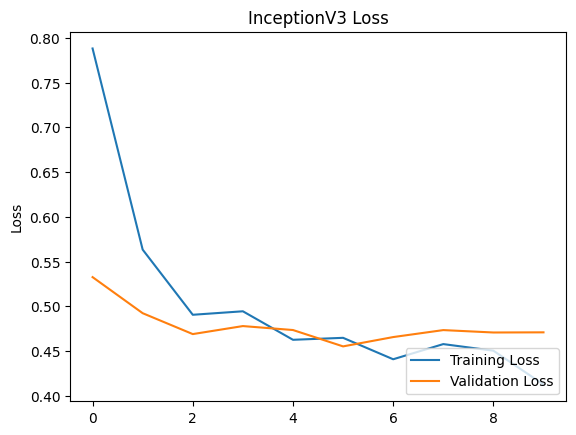

In [63]:
acc = hist_inc.history['loss']
val_acc = hist_inc.history['val_loss']

plt.plot(acc, label='Training Loss')
plt.plot(val_acc, label='Validation Loss')
plt.legend(loc='lower right')
plt.ylabel('Loss')
plt.ylim([min(plt.ylim()),max(plt.ylim())])
plt.title('InceptionV3 Loss')
plt.show()

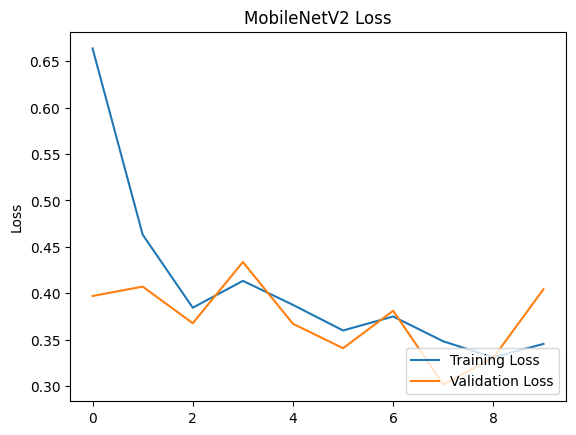

In [64]:
acc = hist_mob.history['loss']
val_acc = hist_mob.history['val_loss']

plt.plot(acc, label='Training Loss')
plt.plot(val_acc, label='Validation Loss')
plt.legend(loc='lower right')
plt.ylabel('Loss')
plt.ylim([min(plt.ylim()),max(plt.ylim())])
plt.title('MobileNetV2 Loss')
plt.show()

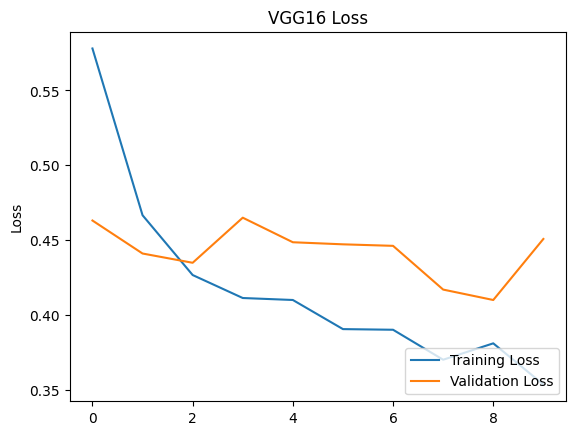

In [65]:
acc = hist_vgg.history['loss']
val_acc = hist_vgg.history['val_loss']

plt.plot(acc, label='Training Loss')
plt.plot(val_acc, label='Validation Loss')
plt.legend(loc='lower right')
plt.ylabel('Loss')
plt.ylim([min(plt.ylim()),max(plt.ylim())])
plt.title('VGG16 Loss')
plt.show()

## 2


## Accuracy Curves

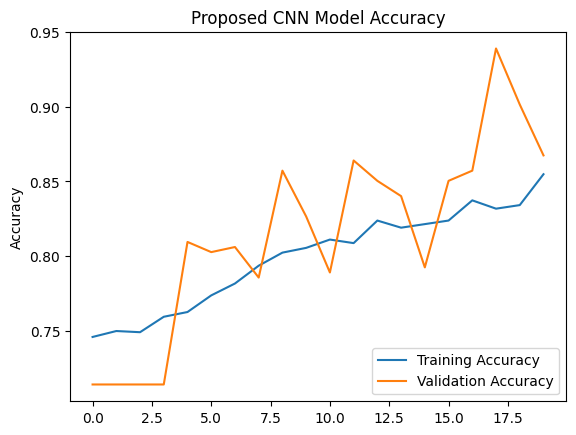

In [66]:
acc = hist_cnn2.history['accuracy']
val_acc = hist_cnn2.history['val_accuracy']

plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),max(plt.ylim())])
plt.title('Proposed CNN Model Accuracy')
plt.show()

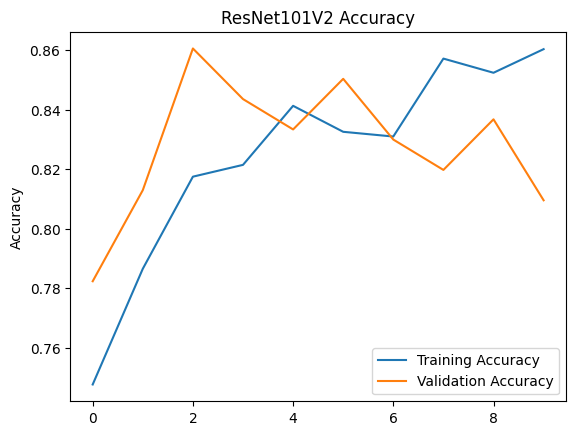

In [94]:
acc = hist_res2.history['accuracy']
val_acc = hist_res2.history['val_accuracy']

plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),max(plt.ylim())])
plt.title('ResNet101V2 Accuracy')
plt.show()

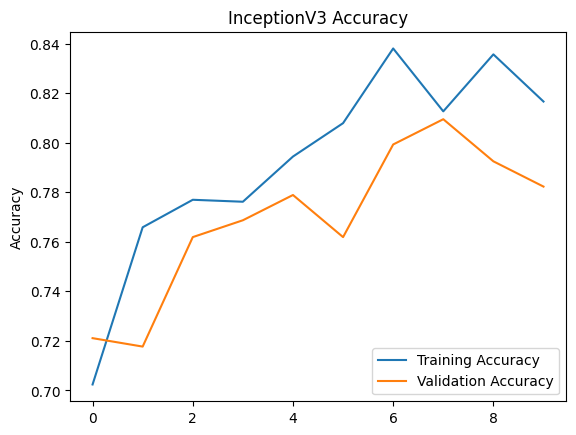

In [68]:
acc = hist_inc2.history['accuracy']
val_acc = hist_inc2.history['val_accuracy']

plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),max(plt.ylim())])
plt.title('InceptionV3 Accuracy')
plt.show()

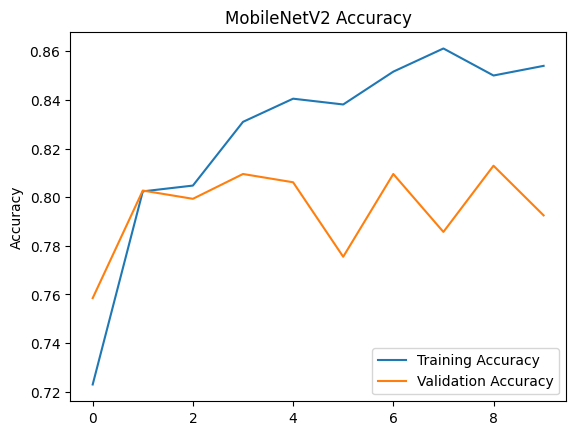

In [69]:
acc = hist_mob2.history['accuracy']
val_acc = hist_mob2.history['val_accuracy']

plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),max(plt.ylim())])
plt.title('MobileNetV2 Accuracy')
plt.show()

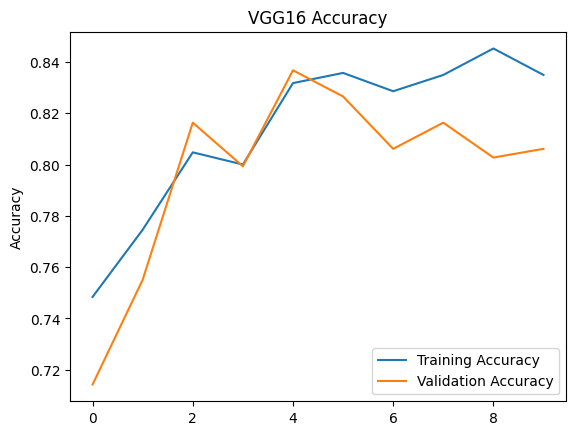

In [70]:
acc = hist_vgg2.history['accuracy']
val_acc = hist_vgg2.history['val_accuracy']

plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),max(plt.ylim())])
plt.title('VGG16 Accuracy')
plt.show()

## Loss Curves

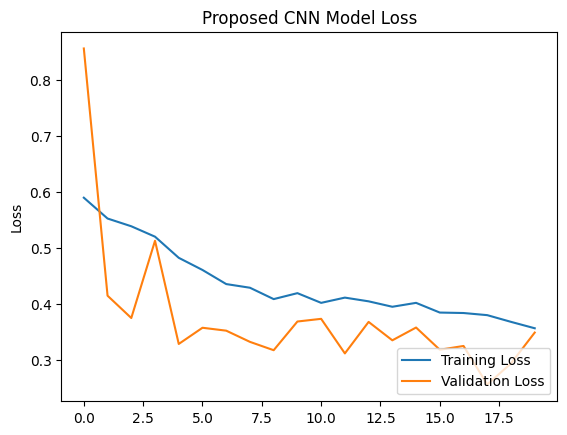

In [71]:
acc = hist_cnn2.history['loss']
val_acc = hist_cnn2.history['val_loss']

plt.plot(acc, label='Training Loss')
plt.plot(val_acc, label='Validation Loss')
plt.legend(loc='lower right')
plt.ylabel('Loss')
plt.ylim([min(plt.ylim()),max(plt.ylim())])
plt.title('Proposed CNN Model Loss')
plt.show()

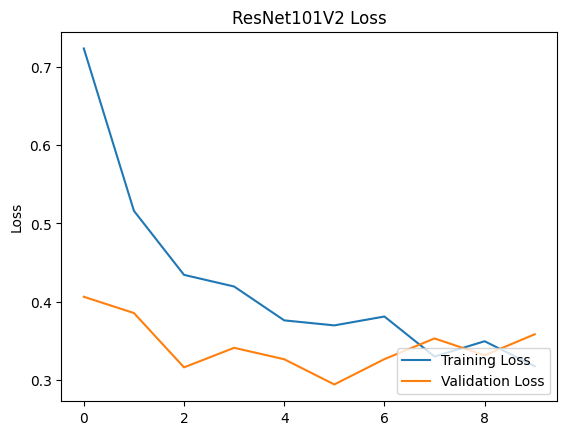

In [95]:
acc = hist_res2.history['loss']
val_acc = hist_res2.history['val_loss']

plt.plot(acc, label='Training Loss')
plt.plot(val_acc, label='Validation Loss')
plt.legend(loc='lower right')
plt.ylabel('Loss')
plt.ylim([min(plt.ylim()),max(plt.ylim())])
plt.title('ResNet101V2 Loss')
plt.show()

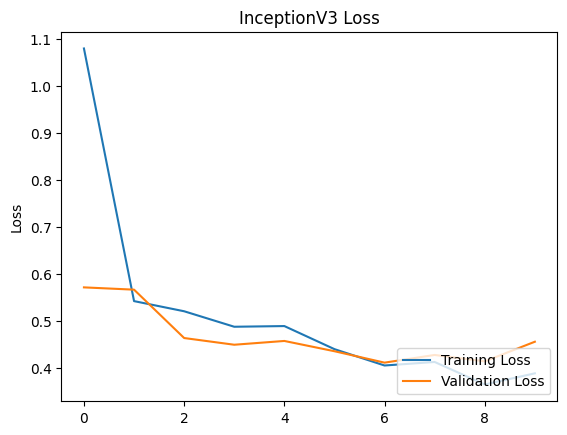

In [73]:
acc = hist_inc2.history['loss']
val_acc = hist_inc2.history['val_loss']

plt.plot(acc, label='Training Loss')
plt.plot(val_acc, label='Validation Loss')
plt.legend(loc='lower right')
plt.ylabel('Loss')
plt.ylim([min(plt.ylim()),max(plt.ylim())])
plt.title('InceptionV3 Loss')
plt.show()

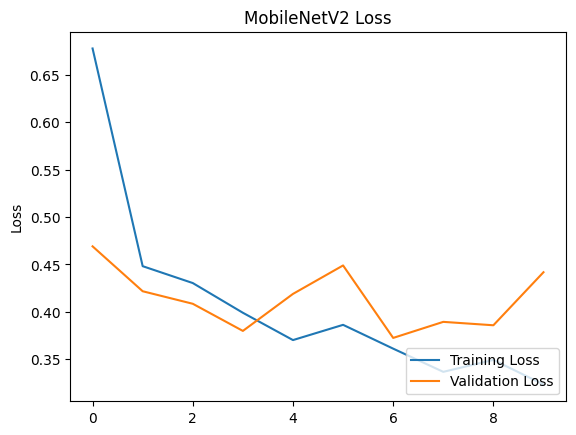

In [74]:
acc = hist_mob2.history['loss']
val_acc = hist_mob2.history['val_loss']

plt.plot(acc, label='Training Loss')
plt.plot(val_acc, label='Validation Loss')
plt.legend(loc='lower right')
plt.ylabel('Loss')
plt.ylim([min(plt.ylim()),max(plt.ylim())])
plt.title('MobileNetV2 Loss')
plt.show()

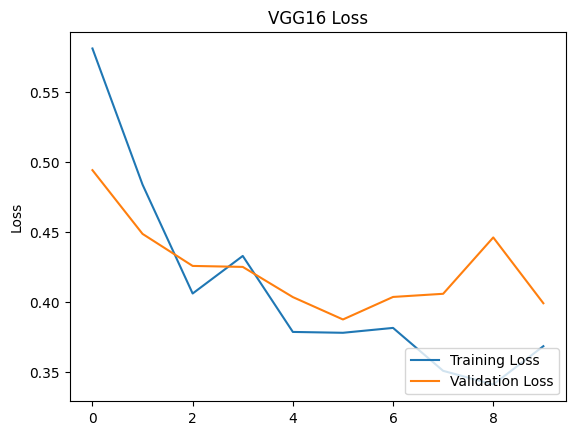

In [75]:
acc = hist_vgg2.history['loss']
val_acc = hist_vgg2.history['val_loss']

plt.plot(acc, label='Training Loss')
plt.plot(val_acc, label='Validation Loss')
plt.legend(loc='lower right')
plt.ylabel('Loss')
plt.ylim([min(plt.ylim()),max(plt.ylim())])
plt.title('VGG16 Loss')
plt.show()

## 3


## Accuracy Curves

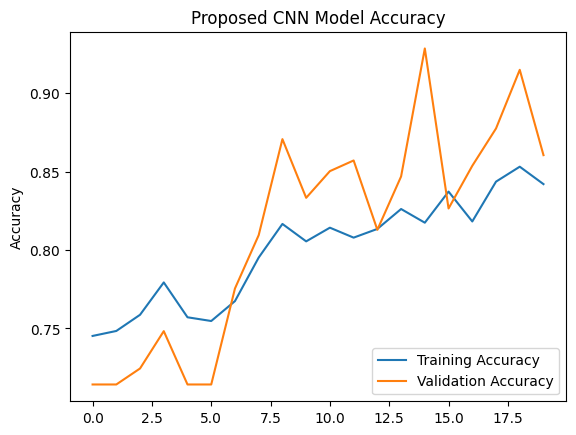

In [76]:
acc = hist_cnn3.history['accuracy']
val_acc = hist_cnn3.history['val_accuracy']

plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),max(plt.ylim())])
plt.title('Proposed CNN Model Accuracy')
plt.show()

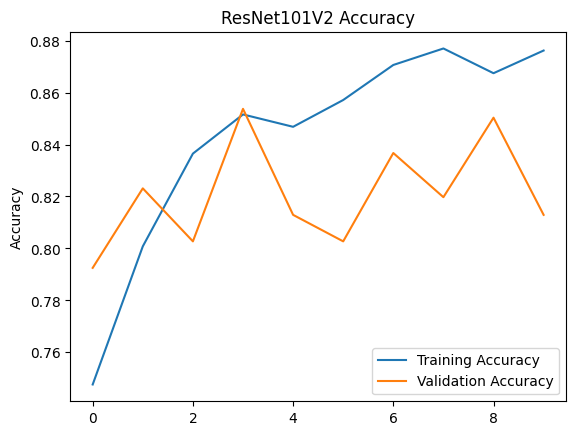

In [96]:
acc = hist_res3.history['accuracy']
val_acc = hist_res3.history['val_accuracy']

plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),max(plt.ylim())])
plt.title('ResNet101V2 Accuracy')
plt.show()

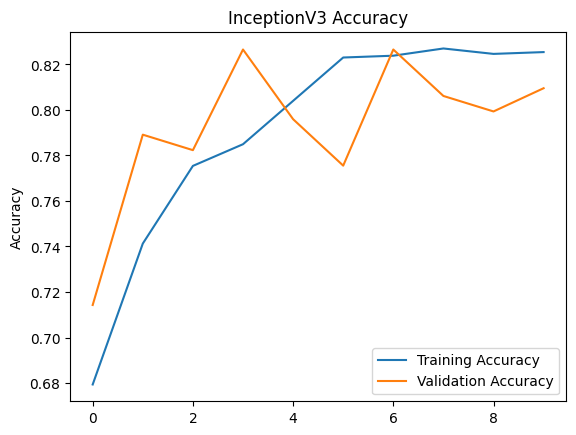

In [78]:
acc = hist_inc3.history['accuracy']
val_acc = hist_inc3.history['val_accuracy']

plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),max(plt.ylim())])
plt.title('InceptionV3 Accuracy')
plt.show()

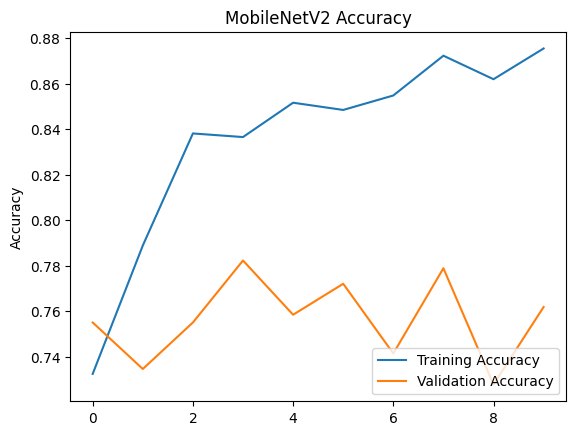

In [79]:
acc = hist_mob3.history['accuracy']
val_acc = hist_mob3.history['val_accuracy']

plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),max(plt.ylim())])
plt.title('MobileNetV2 Accuracy')
plt.show()

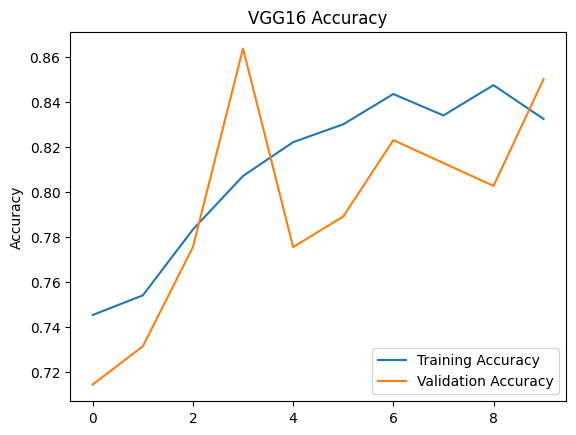

In [80]:
acc = hist_vgg3.history['accuracy']
val_acc = hist_vgg3.history['val_accuracy']

plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),max(plt.ylim())])
plt.title('VGG16 Accuracy')
plt.show()

## Loss Curves

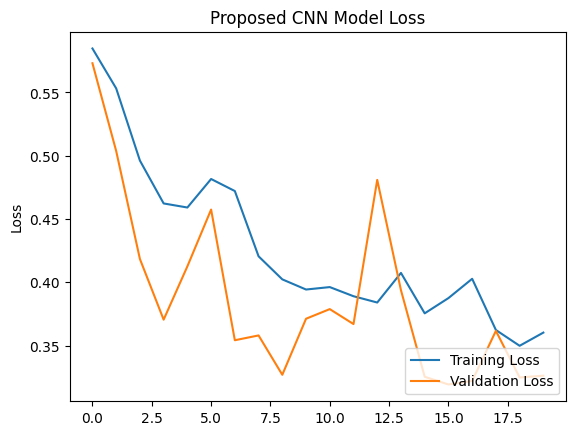

In [81]:
acc = hist_cnn3.history['loss']
val_acc = hist_cnn3.history['val_loss']

plt.plot(acc, label='Training Loss')
plt.plot(val_acc, label='Validation Loss')
plt.legend(loc='lower right')
plt.ylabel('Loss')
plt.ylim([min(plt.ylim()),max(plt.ylim())])
plt.title('Proposed CNN Model Loss')
plt.show()

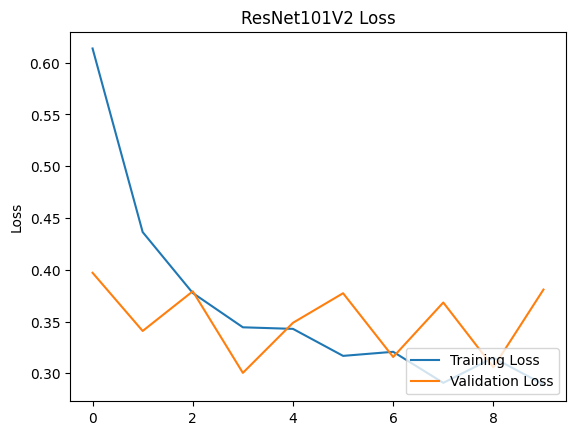

In [97]:
acc = hist_res3.history['loss']
val_acc = hist_res3.history['val_loss']

plt.plot(acc, label='Training Loss')
plt.plot(val_acc, label='Validation Loss')
plt.legend(loc='lower right')
plt.ylabel('Loss')
plt.ylim([min(plt.ylim()),max(plt.ylim())])
plt.title('ResNet101V2 Loss')
plt.show()

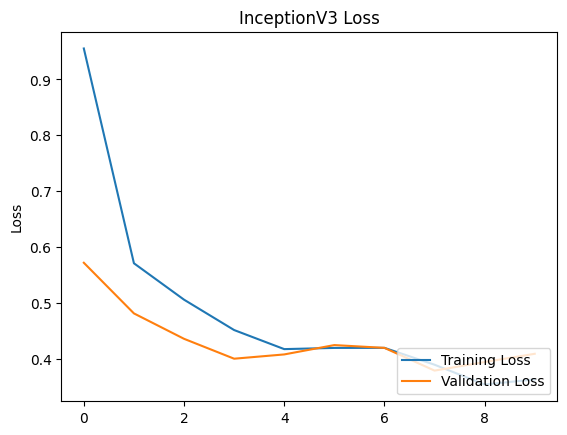

In [83]:
acc = hist_inc3.history['loss']
val_acc = hist_inc3.history['val_loss']

plt.plot(acc, label='Training Loss')
plt.plot(val_acc, label='Validation Loss')
plt.legend(loc='lower right')
plt.ylabel('Loss')
plt.ylim([min(plt.ylim()),max(plt.ylim())])
plt.title('InceptionV3 Loss')
plt.show()

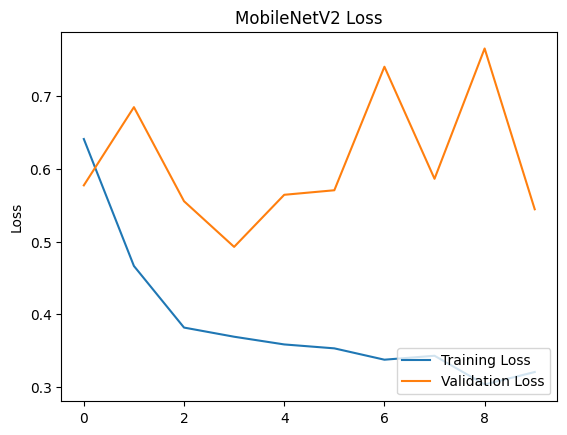

In [84]:
acc = hist_mob3.history['loss']
val_acc = hist_mob3.history['val_loss']

plt.plot(acc, label='Training Loss')
plt.plot(val_acc, label='Validation Loss')
plt.legend(loc='lower right')
plt.ylabel('Loss')
plt.ylim([min(plt.ylim()),max(plt.ylim())])
plt.title('MobileNetV2 Loss')
plt.show()

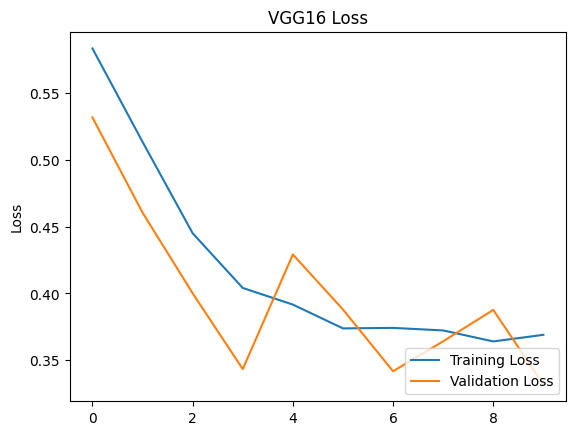

In [85]:
acc = hist_vgg3.history['loss']
val_acc = hist_vgg3.history['val_loss']

plt.plot(acc, label='Training Loss')
plt.plot(val_acc, label='Validation Loss')
plt.legend(loc='lower right')
plt.ylabel('Loss')
plt.ylim([min(plt.ylim()),max(plt.ylim())])
plt.title('VGG16 Loss')
plt.show()